In [36]:
import polars as pl
import polars.selectors as cs
import xgboost as xgb
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

In [37]:
df = (
    pl.scan_csv("/kaggle/input/kepler-exoplanet-search-results/cumulative.csv")
    .drop(["rowid", "kepid", "kepoi_name", "kepler_name"])
    .cast({cs.string(): pl.Categorical})
    .with_columns(cs.categorical().to_physical())
    .collect()
)
df

koi_disposition,koi_pdisposition,koi_score,koi_fpflag_nt,koi_fpflag_ss,koi_fpflag_co,koi_fpflag_ec,koi_period,koi_period_err1,koi_period_err2,koi_time0bk,koi_time0bk_err1,koi_time0bk_err2,koi_impact,koi_impact_err1,koi_impact_err2,koi_duration,koi_duration_err1,koi_duration_err2,koi_depth,koi_depth_err1,koi_depth_err2,koi_prad,koi_prad_err1,koi_prad_err2,koi_teq,koi_teq_err1,koi_teq_err2,koi_insol,koi_insol_err1,koi_insol_err2,koi_model_snr,koi_tce_plnt_num,koi_tce_delivname,koi_steff,koi_steff_err1,koi_steff_err2,koi_slogg,koi_slogg_err1,koi_slogg_err2,koi_srad,koi_srad_err1,koi_srad_err2,ra,dec,koi_kepmag
u32,u32,f64,i64,i64,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,u32,u32,f64,f64,f64,f64,i64,u32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0,0,1.0,0,0,0,0,9.488036,0.000028,-0.000028,170.53875,0.00216,-0.00216,0.146,0.318,-0.146,2.9575,0.0819,-0.0819,615.8,19.5,-19.5,2.26,0.26,-0.15,793.0,null,null,93.59,29.45,-16.65,35.8,1,0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
0,0,0.969,0,0,0,0,54.418383,0.0002479,-0.000248,162.51384,0.00352,-0.00352,0.586,0.059,-0.443,4.507,0.116,-0.116,874.8,35.5,-35.5,2.83,0.32,-0.19,443.0,null,null,9.11,2.87,-1.62,25.8,2,0,5455.0,81.0,-81.0,4.467,0.064,-0.096,0.927,0.105,-0.061,291.93423,48.141651,15.347
1,1,0.0,0,1,0,0,19.89914,0.000015,-0.000015,175.850252,0.000581,-0.000581,0.969,5.126,-0.077,1.7822,0.0341,-0.0341,10829.0,171.0,-171.0,14.6,3.92,-1.31,638.0,null,null,39.3,31.04,-10.49,76.3,1,0,5853.0,158.0,-176.0,4.544,0.044,-0.176,0.868,0.233,-0.078,297.00482,48.134129,15.436
1,1,0.0,0,1,0,0,1.736952,2.6300e-7,-2.6300e-7,170.307565,0.000115,-0.000115,1.276,0.115,-0.092,2.40641,0.00537,-0.00537,8079.2,12.8,-12.8,33.46,8.5,-2.83,1395.0,null,null,891.96,668.95,-230.35,505.6,1,0,5805.0,157.0,-174.0,4.564,0.053,-0.168,0.791,0.201,-0.067,285.53461,48.28521,15.597
0,0,1.0,0,0,0,0,2.525592,0.000004,-0.000004,171.59555,0.00113,-0.00113,0.701,0.235,-0.478,1.6545,0.042,-0.042,603.3,16.9,-16.9,2.75,0.88,-0.35,1406.0,null,null,926.16,874.33,-314.24,40.9,1,0,6031.0,169.0,-211.0,4.438,0.07,-0.21,1.046,0.334,-0.133,288.75488,48.2262,15.509
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1,1,0.0,0,0,0,1,8.5898708,0.0001846,-0.000185,132.0161,0.0157,-0.0157,0.765,0.023,-0.541,4.806,0.634,-0.634,87.7,13.0,-13.0,1.11,0.32,-0.23,929.0,null,null,176.4,152.77,-77.6,8.4,1,0,5638.0,169.0,-152.0,4.296,0.231,-0.189,1.088,0.313,-0.228,298.74921,46.973351,14.478
1,1,0.0,0,1,1,0,0.527699,1.1600e-7,-1.1600e-7,131.705093,0.00017,-0.00017,1.252,0.051,-0.049,3.2221,0.0174,-0.0174,1579.2,4.6,-4.6,29.35,7.7,-2.57,2088.0,null,null,4500.53,3406.38,-1175.26,453.3,1,0,5638.0,139.0,-166.0,4.529,0.035,-0.196,0.903,0.237,-0.079,297.18875,47.093819,14.082
2,0,0.497,0,0,0,0,1.739849,0.0000178,-0.000018,133.00127,0.00769,-0.00769,0.043,0.423,-0.043,3.114,0.229,-0.229,48.5,5.4,-5.4,0.72,0.24,-0.08,1608.0,null,null,1585.81,1537.86,-502.22,10.6,1,0,6119.0,165.0,-220.0,4.444,0.056,-0.224,1.031,0.341,-0.114,286.50937,47.163219,14.757


In [38]:
y = df.get_column("koi_disposition")
X = df.drop("koi_disposition")
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)

In [39]:
clf = xgb.XGBClassifier()
clf.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_val, y_val)])

[0]	validation_0-mlogloss:0.77595	validation_1-mlogloss:0.78805
[1]	validation_0-mlogloss:0.58731	validation_1-mlogloss:0.60825
[2]	validation_0-mlogloss:0.46319	validation_1-mlogloss:0.49161
[3]	validation_0-mlogloss:0.37801	validation_1-mlogloss:0.41262
[4]	validation_0-mlogloss:0.31610	validation_1-mlogloss:0.35735
[5]	validation_0-mlogloss:0.27111	validation_1-mlogloss:0.31697
[6]	validation_0-mlogloss:0.23849	validation_1-mlogloss:0.28813
[7]	validation_0-mlogloss:0.21288	validation_1-mlogloss:0.26713
[8]	validation_0-mlogloss:0.19268	validation_1-mlogloss:0.25150
[9]	validation_0-mlogloss:0.17776	validation_1-mlogloss:0.24121
[10]	validation_0-mlogloss:0.16413	validation_1-mlogloss:0.23235
[11]	validation_0-mlogloss:0.15415	validation_1-mlogloss:0.22564
[12]	validation_0-mlogloss:0.14593	validation_1-mlogloss:0.22091
[13]	validation_0-mlogloss:0.13964	validation_1-mlogloss:0.21694
[14]	validation_0-mlogloss:0.13254	validation_1-mlogloss:0.21430
[15]	validation_0-mlogloss:0.12664	

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

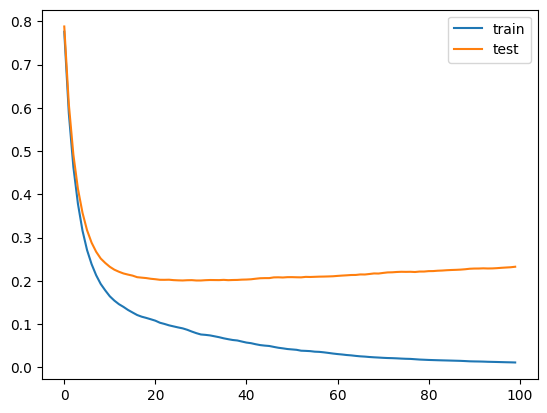

In [40]:
results = clf.evals_result()
plt.plot(results['validation_0']['mlogloss'], label='train')
plt.plot(results['validation_1']['mlogloss'], label='test')
plt.legend()
plt.show()